In [1]:
%%capture
%cd ..

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import HTML, display
from typing import Callable
from celluloid import Camera
from modules.derivatives import second_derivative_4
from multiprocessing import Pool
from os import cpu_count
cpu_count()

8

In [3]:
from dataclasses import dataclass
from collections.abc import Callable

@dataclass
class HProblem1D:
    dt: float
    dx: float
    L:  float
    f:  Callable
    g:  Callable
    x0: float=0
    u:  float=1
    left_free:  bool=False
    right_free: bool=False
    h:  Callable=None

    def __post_init__(self):
        self.N = int((self.L - self.x0)/self.dx)
        self.x = np.linspace(self.x0, self.L, self.N)
        self._t = [0, self.dt]
        f = self.f(self.x)
        self._Y = [f[1:-1]]
        self._Y.append(
            f[1:-1] + self.dt*self.g(self.x[1:-1]) + (self.dt**2/2)*(self.get_h(0) + self.u**2*second_derivative_4(f, self.dx))
        )
        self._f0 = self.f(self.x0)
        self._fL = self.f(self.L)

    def _get_alpha(self, i):
        return self._f0 if not self.left_free else self._Y[i][0]
    
    def _get_beta(self, i):
        return self._fL if not self.right_free else self._Y[i][-1]
    
    @property
    def y(self):
        return np.r_[self._get_alpha(-1), self._Y[-1], self._get_beta(-1)]
    
    @property
    def t(self):
        return np.stack(self._t)
    
    @property
    def Y(self):
        return np.stack([
            np.r_[
                self._get_alpha(i), 
                self._Y[i], 
                self._get_beta(i),
            ] 
            for i in range(len(self._Y))
        ])
    
    @property
    def b(self):
        return np.r_[self._get_alpha(-1), np.zeros(self.N-4), self._get_beta(-1)]
    
    def get_h(self, i):
        if self.h == None:
            return 0
        else:
            return self.h(self._t[i], self.x[1:-1], self._Y[i])
    
    def get_grid_extents(self):
        return self.x.min(), self.x.max(), self.t.min(), self.t.max()
    
    def run(self, steps: int):
        for _ in range(steps):
            self.step()

class Wave1D(HProblem1D):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.lamb = (self.u*self.dt/self.dx)**2
        self.LAMB = 2*(1 - self.lamb)*np.identity(self.N-2) + self.lamb*(np.diagflat(np.ones(self.N-3), 1) + np.diagflat(np.ones(self.N-3), -1))
    
    def step(self):
        self._Y.append(self.LAMB.dot(self._Y[-1]) - self._Y[-2] + self.lamb*self.b + self.dt**2*self.get_h(-1))
        self._t.append(self._t[-1] + self.dt)

In [4]:
def show(animation):
    plt.close()
    return HTML(animation.to_html5_video())

In [ ]:
wave = Wave1D(
    dt= 0.01,
    dx= 0.05,
    L= 1,
    f= (lambda x: np.sin(np.pi*x)),
    g= (lambda x: 0),
    u= 1
)

camera = Camera(plt.gcf())
for _ in range(500):
    wave.step()
    plt.plot(wave.x, wave.y, 'C0-')
    camera.snap()
show(camera.animate(interval=5))

In [ ]:
wave = Wave1D(
    dt= 0.01,
    dx= 0.05,
    L= 10,
    f= (lambda x: np.exp(-x**2)),
    g= (lambda x: 0),
    u= 2,
    left_free= True
)

camera = Camera(plt.gcf())
for _ in range(1000):
    wave.step()
    plt.plot(wave.x, wave.y, 'C0-')
    camera.snap()
show(camera.animate(interval=5))

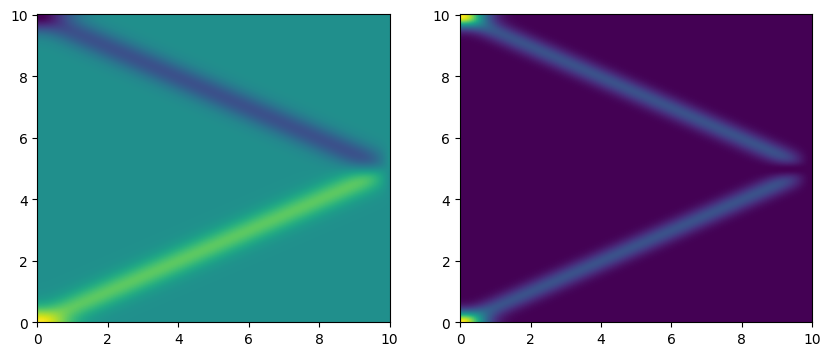

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.imshow(wave.Y, aspect='auto', origin='lower', extent=wave.get_grid_extents())
ax2.imshow(wave.Y**2, aspect='auto', origin='lower', extent=wave.get_grid_extents())
plt.show()

In [ ]:
problem = HProblem1D(
    dt= 0.01,
    dx= 0.05,
    L= 10,
    f= (lambda x: np.exp(-(x - 5)**2)),
    g= (lambda x: 0),
    u= 2
)
params = problem.dict()
T = 1000

def task(left_free: bool):
    params['left_free'] = left_free
    wave = Wave1D(**params)
    wave.run(T)
    return wave.Y

with Pool(cpu_count()) as executor:
    solutions = executor.map(task, (False, True))

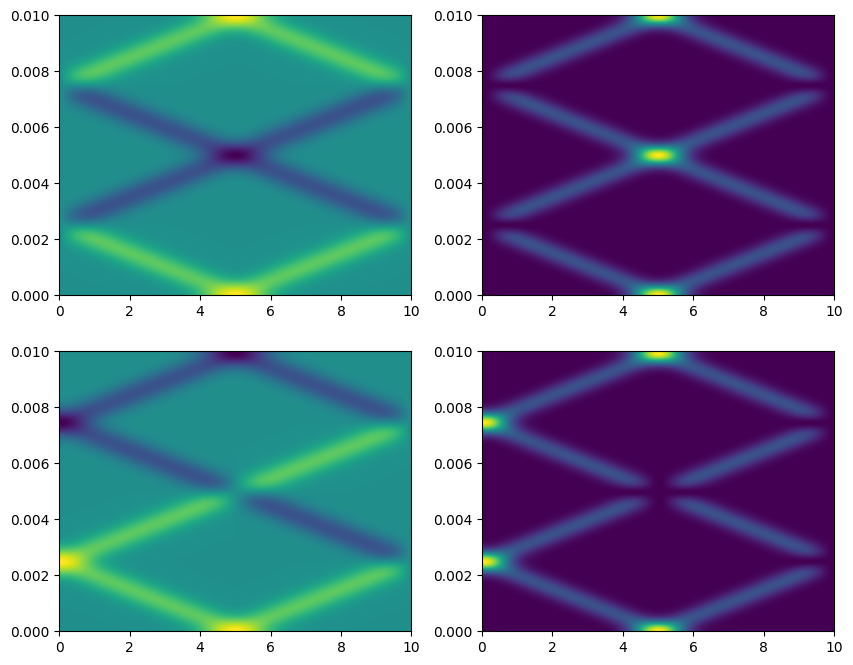

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
for i, Y in enumerate(solutions):
    axs[i][0].imshow(Y, aspect='auto', origin='lower', extent=problem.get_grid_extents())
    axs[i][1].imshow(Y**2, aspect='auto', origin='lower', extent=problem.get_grid_extents())
plt.show()

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
camera = Camera(fig)
for j in range(T):
    for i, Y in enumerate(solutions):
        axs[i].plot(problem.x, Y[j], 'C0-')
    camera.snap()
show(camera.animate(interval=5)) 

In [5]:
@dataclass
class Kink:
    v: float
    c: float
    lamb: float

    def __post_init__(self):
        beta = self.v/self.c
        self.gamma = 1/(1 - beta**2)**0.5
        self.delta = (2/self.lamb)**0.5
    
    def Z(self, x, t):
        return self.gamma*(x - self.v*t)
    
    def __call__(self, x, t, x0=0, antikink=False):
        return (-1 if antikink else 1)*np.tanh(self.Z(x=(x - x0), t=t)/self.delta)
    
    def d_dt(self, x, t, x0=0, antikink=False):
        return (-1 if antikink else 1)*(-self.gamma*self.v/self.delta)/np.cosh(self.Z(x=(x - x0), t=t)/self.delta)**2
    
    def static(self, x0=0, antikink=False):
        return (
            lambda x: self.__call__(x=x, t=0, x0=x0, antikink=antikink),
            lambda x: self.d_dt(x=x, t=0, x0=x0, antikink=antikink)
        )
    
    def h(self, t, x, y):
        return self.lamb*y*(1 - y**2)

In [ ]:
kink = Kink(v=0.9, c=1, lamb=2)
f, g = kink.static(x0=1)

wave = Wave1D(
    dt= 0.01,
    dx= 0.05,
    L= 10,
    f= f,
    g= g,
    u= kink.c,
    h= kink.h
)

fig = plt.figure(figsize=(10, 3))
fig.tight_layout()
plt.gca().set_aspect('equal')
camera = Camera(fig)
for _ in range(10000):
    wave.step()
    plt.plot(wave.x, wave.y, 'C0-')
    camera.snap()
show(camera.animate(interval=5))

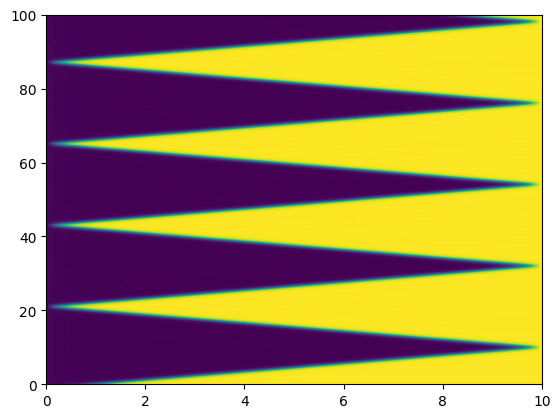

In [ ]:
plt.imshow(wave.Y, aspect='auto', origin='lower', extent=(wave.x.min(), wave.x.max(), wave.t.min(), wave.t.max()))

In [38]:
kink = Kink(v=-0.9, c=1, lamb=2)
f, g = kink.static(x0=9, antikink=True)

wave = Wave1D(
    dt= 0.02,
    dx= 0.05,
    L= 10,
    f= f,
    g= g,
    u= kink.c,
    h= kink.h
)

fig = plt.figure(figsize=(10, 3))
fig.tight_layout()
plt.gca().set_aspect('equal')
camera = Camera(fig)
for _ in range(1000):
    wave.step()
    plt.plot(wave.x, wave.y, 'C0-')
    camera.snap()
show(camera.animate(interval=5))

In [6]:
c = 1
x0 = 10
v = 0.9
kink = Kink(v=v, c=1, lamb=2)
f1, g1 = kink.static(x0=-x0)
f2, g2 = Kink(v=-v, c=1, lamb=2).static(x0=x0, antikink=True)

def f(x):
    return f1(x) + f2(x) - 1

def g(x):
    return g1(x) + g2(x)

wave = Wave1D(
    dt= 0.01,
    dx= 0.05,
    x0= -20,
    L= 20,
    f= f,
    g= g,
    u= c,
    h= kink.h
)

T = (wave.L + x0)/v
M = int(T/wave.dt)

fig = plt.figure(figsize=(10, 3))
plt.gca().set_aspect(3)
camera = Camera(fig)
for _ in range(M):
    wave.step()
    plt.plot(wave.x, wave.y, 'C0-')
    camera.snap()
show(camera.animate(interval=5))

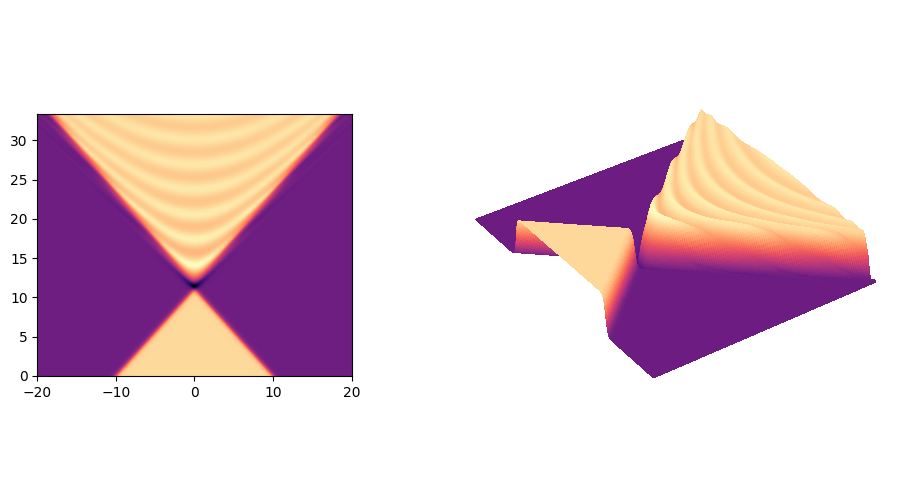

In [29]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(10, 5), tight_layout=True)
gs = gridspec.GridSpec(1, 3, wspace=0.0)

ax1 = fig.add_subplot(gs[0])
ax1.imshow(wave.Y, aspect='auto', origin='lower', extent=(wave.x.min(), wave.x.max(), wave.t.min(), wave.t.max()), cmap='magma')
ax1.set_aspect('equal', 'box')

ax2 = fig.add_subplot(gs[1:], projection='3d')
(X, Y), Z = np.meshgrid(wave.x, wave.t), wave.Y*3
ax2.plot_surface(X, Y, Z, rstride=3, cstride=3, linewidth=0, antialiased=False, cmap='magma')
ax2.view_init(azim=-35, elev=35)
ax2.set_aspect('equal')
ax2.grid(False)
# ax2.set_xlim(wave.x.min(), wave.x.max())
# ax2.set_ylim(wave.t.min(), wave.t.max())
# ax2.set_zlim(-1, 1)
ax2.axis('off')

plt.show()

In [35]:
c = 1
x0 = 10
v = 0.9
kink = Kink(v=v, c=1, lamb=2)
f1, g1 = kink.static(x0=-x0, antikink=True)
f2, g2 = Kink(v=-v, c=1, lamb=2).static(x0=x0)

def f(x):
    return f1(x) + f2(x) + 1

def g(x):
    return g1(x) + g2(x)

wave = Wave1D(
    dt= 0.01,
    dx= 0.05,
    x0= -20,
    L= 20,
    f= f,
    g= g,
    u= c,
    h= kink.h
)

T = (wave.L + x0)/v
M = int(T/wave.dt)

fig = plt.figure(figsize=(10, 3))
plt.gca().set_aspect(3)
camera = Camera(fig)
for _ in range(M):
    wave.step()
    plt.plot(wave.x, wave.y, 'C0-')
    camera.snap()
show(camera.animate(interval=5))

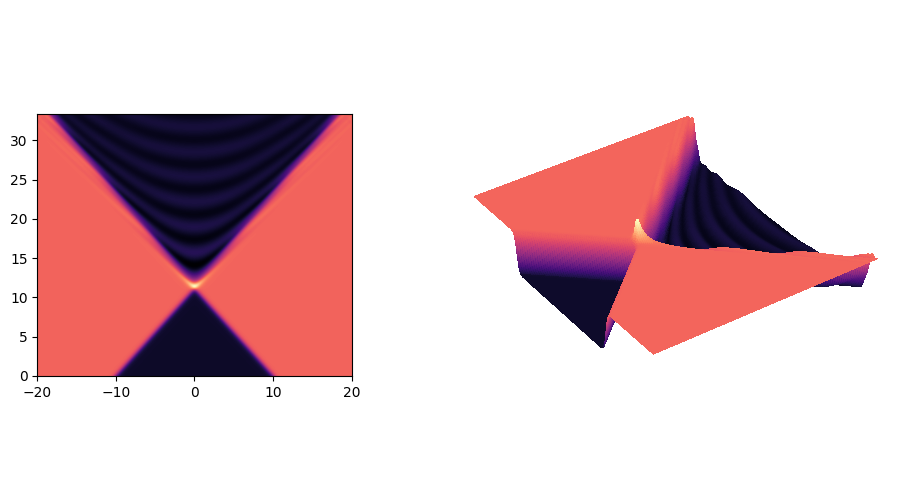

In [36]:
fig = plt.figure(figsize=(10, 5), tight_layout=True)
gs = gridspec.GridSpec(1, 3, wspace=0.0)

ax1 = fig.add_subplot(gs[0])
ax1.imshow(wave.Y, aspect='auto', origin='lower', extent=(wave.x.min(), wave.x.max(), wave.t.min(), wave.t.max()), cmap='magma')
ax1.set_aspect('equal', 'box')

ax2 = fig.add_subplot(gs[1:], projection='3d')
(X, Y), Z = np.meshgrid(wave.x, wave.t), wave.Y*3
ax2.plot_surface(X, Y, Z, rstride=3, cstride=3, linewidth=0, antialiased=False, cmap='magma')
ax2.view_init(azim=-35, elev=35)
ax2.set_aspect('equal')
ax2.grid(False)
ax2.axis('off')

plt.show()